In [1]:
import numpy as np
from meshtools import *
import NeuralField as nf
import FiringRate as fr
import ConnectivityKernel as ck
import QuadratureInTriangles as Qtri
import InitialConditions as ic
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
from scipy.integrate import ode
%matplotlib inline

In [2]:
# Used for Plotting 3D result on linear vectors
def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi)
    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z

In [3]:
# Generate Mesh
Lx=-30; Ux=30
Ly=-30; Uy=30
length = 3
p,v=RectangleSegments([Ux,Uy],[Lx, Ly],edge_length=length)
mesh_pts, elems = DoTriMesh(p,v,edge_length=length)
NT = len(elems) # Number of triangles
print("Number of Elements = " + str(NT))

Number of Elements = 1234


In [4]:
# plot mesh
plot_mesh = False
if(plot_mesh):
    plt.triplot(mesh_pts[:, 0], mesh_pts[:, 1], elems)

In [5]:
Np = 2 # Desired number of gauss points.

gwp = Qtri.getWeightsAndPoints(Np)

weights = gwp[:,2]
x_hat = gwp[:,1]
y_hat = gwp[:,0]

Ng = len(weights) # Actual Number of Gauss points.

In [6]:
# Assemble Mesh of Interior Points
xs = []
As = []
for l, elem in enumerate(elems):
    v1,v2,v3 = mesh_pts[elem] # Get vertices of the element
    A_l = Qtri.computeArea(v1,v2,v3)
    As.append(A_l)
    for j in range(len(weights)):
        new_point = Qtri.mapX(v1, v2, v3, x_hat[j], y_hat[j])
        xs.append(new_point)
xs = np.array(xs)
As = np.array(As)
N = len(xs)

In [7]:
# Initialize Connectivity Kernel
b = 1
kernel = ck.ConnectivityKernel1(b)

In [8]:
%%time
# Assemble Synaptic Matrix
wts_o = np.outer(As.T, weights)
rhos = wts_o.flatten()

W = np.zeros((N,N))
for i in range(0, N):
    x_pt = xs[i]
    for j in range(i, N):
        y_pt = xs[j]
        x, y = x_pt-y_pt
        W[i,j] = kernel(x, y) 
        
# Copy upper triangular part to lower triangular part
i_lower = np.tril_indices(N, -1)
W[i_lower] = W.T[i_lower]

# Multiply times the weights
W *= rhos
del rhos # delete to free memory

CPU times: user 52.3 s, sys: 130 ms, total: 52.4 s
Wall time: 52.4 s


### Time step using standard ODE solvers

In [16]:
# Initial Conditions
_A = 6; _L = 5.77 # parameters for initial condition 1
#_A = 2; _L = 100 # parameters for initial condition 2
initCond = ic.InitialCondition1(_A, _L)

u0 = [] # Synaptic Potential
a0 = [] # Adaptation
for point in xs:
    x,y = point
    init_cond = initCond(x,y)
    u0.append(init_cond)
    a0.append(init_cond)
v0 = np.array(u0 + a0) # Stack u0 on top of a0

In [17]:
# Initialize Firing Rate
p_mu = 50
p_h = 0.6
f_rate = fr.FiringRate1(p_mu, p_h)

# Initialize Neural Field
p_g = 1
p_alph = 1.2
NeuralField = nf.NeuralField(f_rate, W, p_alph, p_g)

In [18]:
%%time
method = ode(NeuralField).set_integrator("dopri5")
method.set_initial_value(v0)
final_t = 15
dt = 0.1
vs = []
time_points = []
while method.t < final_t:
    next_t = method.t+dt
    time_points.append(next_t)
    next_v = method.integrate(next_t)
    vs.append(next_v)

CPU times: user 3min 54s, sys: 1.54 s, total: 3min 56s
Wall time: 59.5 s


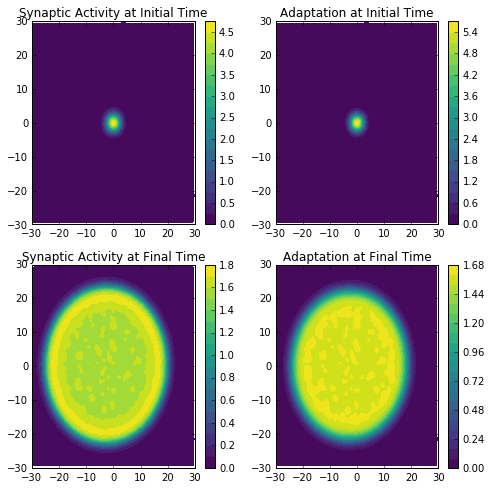

In [19]:
fig = plt.figure(figsize=(8,8))

# Plot initial time of Synaptic Activity
ax11 = fig.add_subplot(221)
xx0, yy0, uu0 = grid(xs[:,0], xs[:,1], vs[0][:Ng*NT])
cont11 = ax11.contourf(xx0, yy0, uu0, 20, cmap=plt.get_cmap('viridis'))
ax11.set_title("Synaptic Activity at Initial Time")
plt.colorbar(cont11)

# Plot initial time of Adaptation
ax12 = fig.add_subplot(222)
xx0, yy0, aa0 = grid(xs[:,0], xs[:,1], vs[0][Ng*NT:])
cont12 = ax12.contourf(xx0, yy0, aa0, 20, cmap=plt.get_cmap('viridis'))
ax12.set_title("Adaptation at Initial Time")
plt.colorbar(cont12)

# Plot final time of Synaptic Activity
ax21 = fig.add_subplot(223)
xn, yn, un1 = grid(xs[:,0], xs[:,1], vs[-1][:Ng*NT])
cont21 = ax21.contourf(xn, yn, un1, 20, cmap=plt.get_cmap('viridis'))
ax21.set_title("Synaptic Activity at Final Time")
plt.colorbar(cont21)

# Plot final time of Adaptation
ax22 = fig.add_subplot(224)
xn, yn, un2 = grid(xs[:,0], xs[:,1], vs[-1][Ng*NT:])
cont22 = ax22.contourf(xn, yn, un2, 20, cmap=plt.get_cmap('viridis'))
ax22.set_title("Adaptation at Final Time")
plt.colorbar(cont22)

plt.savefig("Plots/IC"+str(initCond.num)+"_"+str(NT)+"elems_("+str(p_h)+")h.png")